In [41]:
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd 
import glob
import pymc as pm
import arviz as az
import statistics as stats
import matplotlib.pyplot as plt
import os,sys

In [42]:
# getting the name of the directory
# where the this file is present.
# current = os.path.dirname(os.path.realpath(__file__))
current = os.path.dirname(os.getcwd())
 
# Getting the parent directory name
# where the current directory is present.
# parent = os.path.dirname(os.path.dirname(current))
parent = current
print(parent)
#/Users/pizarror/IDM

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

from IDM_model.src import model_functions as mf

/Users/pizarror/mturk


In [43]:
def read_load_data(subject='23_IDM_0144',fn='/tmp',alpha0=1.0,cols=[]):
    df = pd.read_csv(fn)
    # remove practice trials
    df = df.loc[df['cdd_trial_type']=='task']
    # insert probability as choice into data
    # cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
    # also returns percent_reward which we do not need here
    data = mf.get_data(df,cols,alpha_hat=alpha0)[0]
    data['subject'] = subject
    # vn = data['cdd_immed_amt'].to_list()
    # vr = data['cdd_delay_amt'].to_list()
    # tn = data['cdd_immed_wait'].to_list()
    # tr = data['cdd_delay_wait'].to_list()
    # choice = data['cdd_trial_resp.corr'].to_list()
    return data # vn,vr,tn,tr,choice

## Complete Pooling

Complete pooling ignores the group-level information and considers all data as belonging to the same category. All groups are described with the same model. 

We are using complete pooling to generate priors for when we implement a higherarchical bayesian model.

### Load data

We will load the data from all participants so we can run the modeling schema

In [44]:

# Takes about 16 seconds

# we will change this when we change utility to 1st level analysis (or split)
split_dir = '/Volumes/UCDN/datasets/IDM/split/'
save_dir = '/Volumes/UCDN/datasets/IDM/BH/csv'
subjs = sorted(glob.glob(os.path.join(split_dir,'23_IDM_*')))
task = 'cdd'
# VNa,VRa,TNa,TRa,Cha = [[]]*5
cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
data = pd.DataFrame(columns=['subject']+cols)

for s in subjs:
    subject = os.path.basename(s)
    fn  = os.path.join(s,task,'{}_{}.csv'.format(os.path.basename(s),task))
    if os.path.exists(fn):
        # SSA (Ben's smaller sooner amount) is vn (value_null)
        # LLA (Ben's larger later amount) is vr (value_reward)
        # SSD (Ben's smaller sooner delay) is tn (time_null)
        # LLD (Ben's larger later delay) is tr (time_reward)
        # y_pool (Ben's) is choice 
        # vn,vr,tn,tr,choice = read_load_data(fn=fn,alpha0=1.0)
        subj_data = read_load_data(subject=subject,fn=fn,alpha0=1.0,cols=cols)
        data = pd.concat([data,subj_data],ignore_index=True)
        # VNa = VNa + vn
        # VRa = VRa + vr
        # TNa = TNa + tn
        # TRa = TRa + tr
        # Cha = Cha + choice

print(data)





           subject  cdd_trial_resp.corr  cdd_immed_amt  cdd_delay_amt   
0      23_IDM_0001                  1.0            5.0           26.0  \
1      23_IDM_0001                  1.0            2.0           22.0   
2      23_IDM_0001                  0.0            2.0            6.0   
3      23_IDM_0001                  0.0           15.0           15.0   
4      23_IDM_0001                  1.0           15.0           55.0   
...            ...                  ...            ...            ...   
14299  23_IDM_0149                  1.0            2.0           12.0   
14300  23_IDM_0149                  0.0           20.0           24.0   
14301  23_IDM_0149                  0.0            2.0           41.0   
14302  23_IDM_0149                  1.0           10.0           65.0   
14303  23_IDM_0149                  0.0           20.0           25.0   

       cdd_immed_wait  cdd_delay_wait  alpha  
0                 0.0            29.0    1.0  
1                 0.0        

### 1. Simple Hierarchical Model

Pool all data together and run simple BH model


In [45]:
subjects = data['subject'].unique()
subjects = subjects[:100]
print(subjects)
data = data.loc[data['subject'].isin(subjects)]

print(data)


['23_IDM_0001' '23_IDM_0002' '23_IDM_0003' '23_IDM_0004' '23_IDM_0005'
 '23_IDM_0006' '23_IDM_0007' '23_IDM_0008' '23_IDM_0009' '23_IDM_0010'
 '23_IDM_0011' '23_IDM_0012' '23_IDM_0013' '23_IDM_0014' '23_IDM_0015'
 '23_IDM_0016' '23_IDM_0017' '23_IDM_0018' '23_IDM_0019' '23_IDM_0020'
 '23_IDM_0021' '23_IDM_0022' '23_IDM_0023' '23_IDM_0024' '23_IDM_0025'
 '23_IDM_0026' '23_IDM_0027' '23_IDM_0028' '23_IDM_0029' '23_IDM_0030'
 '23_IDM_0031' '23_IDM_0032' '23_IDM_0033' '23_IDM_0034' '23_IDM_0035'
 '23_IDM_0036' '23_IDM_0037' '23_IDM_0038' '23_IDM_0039' '23_IDM_0040'
 '23_IDM_0041' '23_IDM_0042' '23_IDM_0043' '23_IDM_0044' '23_IDM_0045'
 '23_IDM_0046' '23_IDM_0047' '23_IDM_0048' '23_IDM_0049' '23_IDM_0050']
          subject  cdd_trial_resp.corr  cdd_immed_amt  cdd_delay_amt   
0     23_IDM_0001                  1.0            5.0           26.0  \
1     23_IDM_0001                  1.0            2.0           22.0   
2     23_IDM_0001                  0.0            2.0            6.0   
3

In [46]:

# takes approximately 6-10 ,minutes for 10 subjects

subjects = data['subject'].unique()
nb_subj = subjects.shape[0]
nb_trials = data.shape[0]//nb_subj
subj_id = np.array([ [s]*nb_trials for s in range(nb_subj) ]).flatten()

delay_amt = data['cdd_delay_amt'].values
delay_wait = data['cdd_delay_wait'].values
immed_amt = data['cdd_immed_amt'].values
immed_wait = data['cdd_immed_wait'].values
choices = data['cdd_trial_resp.corr'].values


# for iSubj,s in enumerate(subjects):
#     print('Working on modeling for subject : {}'.format(s))
#     delay_amt[iSubj,:] = data.loc[data['subject']==s]['cdd_delay_amt'].values
#     # if len(delay_amt)!=96:
#     #     print('Whoops dataset is not right size : check subject {}'.format(s))
#     #     sys.exit()
#     delay_wait[iSubj,:] = data.loc[data['subject']==s]['cdd_delay_wait'].values
#     immed_amt[iSubj,:] = data.loc[data['subject']==s]['cdd_immed_amt'].values
#     immed_wait[iSubj,:] = data.loc[data['subject']==s]['cdd_immed_wait'].values
#     choices[iSubj,:] = data.loc[data['subject']==s]['cdd_trial_resp.corr'].values
    
# print(delay_wait.shape)

In [47]:
fn = os.path.join(save_dir,'completely_pooled_model.csv')
pool_model = pd.read_csv(fn,index_col=0)

mu_kappa_hat,std_kappa_hat = pool_model.loc['kappa[0]','mean'],pool_model.loc['kappa[0]','sd']
mu_gamma_hat,std_gamma_hat = pool_model.loc['gamma[0]','mean'],pool_model.loc['gamma[0]','sd']

print('For kappa, use the following (mu,sigma) : ({},{})'.format(mu_kappa_hat, std_kappa_hat))
print('For gamma, use the following (mu,sigma) : ({},{})'.format(mu_gamma_hat, std_gamma_hat))

For kappa, use the following (mu,sigma) : (0.0199494192,0.0004967748)
For gamma, use the following (mu,sigma) : (0.1290928433,0.0027119263)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 388 seconds.
/Users/pizarror/opt/anaconda3/envs/idm_jupy/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (100), generating only 20 plots
  warnings.warn(


Saving to : /Volumes/UCDN/datasets/IDM/BH/csv/simple_BH_model.csv


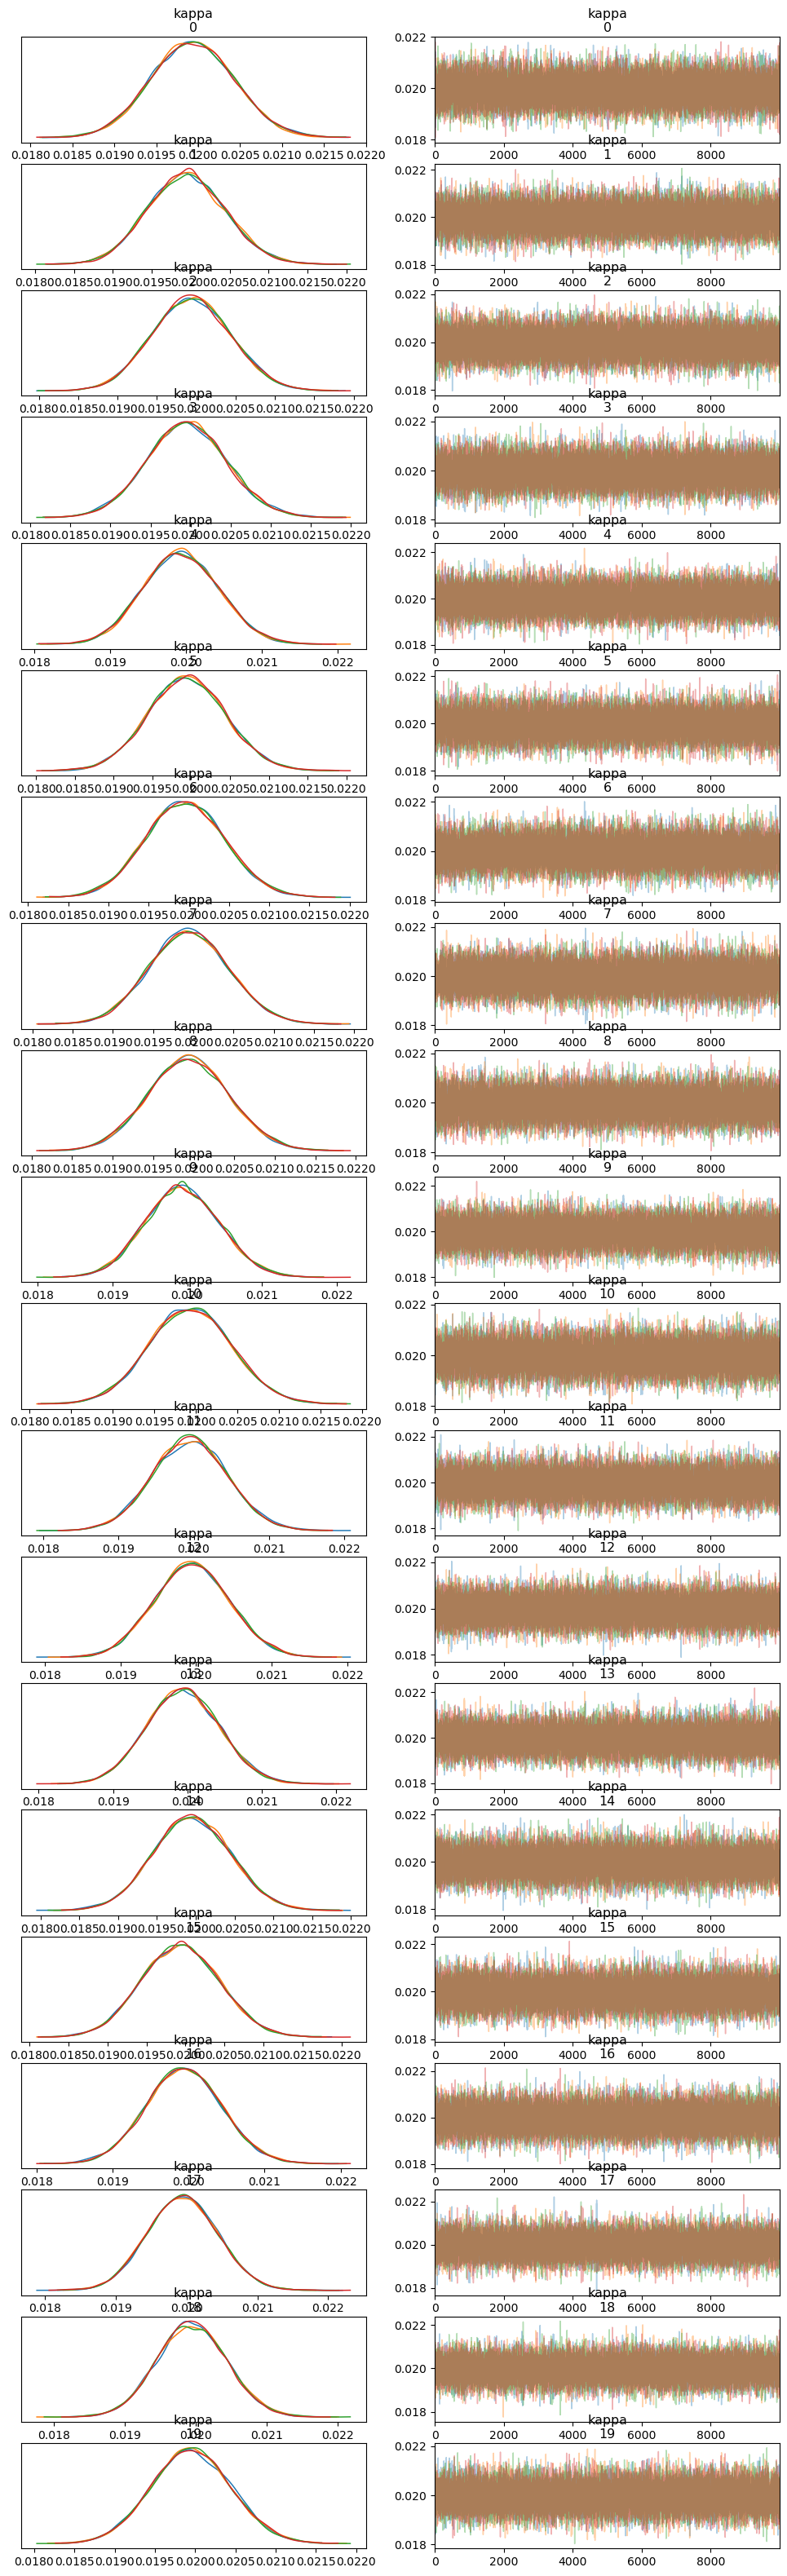

In [48]:


# We will fit a model for each subject
with pm.Model() as model_simple:

    # Hyperparameters for k
    # mu_kappa_hyper = pm.Beta('mu_kappa_hyper',mu=mu_kappa_hat,sigma=0.05)
    # sd_kappa_hyper = pm.Beta('sd_kappa_hyper',mu=std_kappa_hat,sigma=0.05)

    # use above mean and stdev to define kappa and gamma, the posterior from the pooled is now our prior
    kappa = pm.Beta('kappa',mu=mu_kappa_hat,sigma=std_kappa_hat,shape=np.size(np.unique(subj_id)))
    gamma = pm.HalfNormal('gamma',sigma=std_gamma_hat,shape=np.size(np.unique(subj_id)))
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * ( delay_amt/(1+(kappa[subj_id]*delay_wait)) 
                                                                            - immed_amt/(1+(kappa[subj_id]*immed_wait)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

    trace_prior = pm.sample(10000, tune=10000, cores=4,target_accept=0.95)

# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
az.plot_trace(trace_prior, var_names=["kappa","gamma"],compact=False)
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
summary= az.summary(trace_prior,round_to=10)
fn = os.path.join(save_dir,"simple_BH_model.csv")
# Again, call it what you want (yeah - call it what you want tooooo)
print('Saving to : {}'.format(fn))
summary.to_csv(fn)